In [1]:
import os
import re

from dotenv import load_dotenv
from langchain import hub
from langchain.agents import AgentType, load_tools
from langchain_experimental.tools import PythonREPLTool
from langchain.agents.initialize import initialize_agent
from langchain.agents import create_react_agent, AgentExecutor
from langchain.agents.format_scratchpad import format_log_to_str
from langchain.agents.output_parsers import JSONAgentOutputParser
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
# from langchain.chat_models import ChatOpenAI
# from langchain.llms import OpenAI
from langchain_openai import ChatOpenAI
from langchain.tools import ArxivQueryRun, WikipediaQueryRun
from langchain.tools.render import render_text_description_and_args
from langchain.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain.prompts import MessagesPlaceholder

# from langchain.schema import ChatMessage, SystemMessage
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.callbacks.base import BaseCallbackManager

from llamp.mp.agents import (
    MPSummaryExpert,
    MPThermoExpert,
    MPElasticityExpert,
    MPDielectricExpert,
    MPPiezoelectricExpert,
    MPMagnetismExpert,
    MPElectronicExpert,
    MPSynthesisExpert,
    MPStructureRetriever,
)
# from llamp.arxiv.agents import ArxivAgent

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", None)
OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION", None)

OPENAI_GPT_MODEL = "gpt-4-1106-preview"
# OPENAI_GPT_MODEL = "gpt-4-0125-preview"
# OPENAI_GPT_MODEL = "gpt-3.5-turbo-1106"
# OPENAI_GPT_MODEL = "gpt-4"

No module named 'phonopy'
No module named 'phonopy'


In [2]:
top_llm = ChatOpenAI(
    temperature=0.1,
    model=OPENAI_GPT_MODEL,
    openai_api_key=OPENAI_API_KEY,
    openai_organization=OPENAI_ORGANIZATION,
    streaming=False,
    callbacks=[StreamingStdOutCallbackHandler()],
)

bottom_callback_handler = StreamingStdOutCallbackHandler()

bottom_llm = ChatOpenAI(
    temperature=0,
    model=OPENAI_GPT_MODEL,
    openai_api_key=OPENAI_API_KEY,
    openai_organization=OPENAI_ORGANIZATION,
    max_retries=5,
    streaming=True,
    callbacks=[bottom_callback_handler],
)


wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
arxiv = ArxivQueryRun(api_wrapper=ArxivAPIWrapper())

tools = load_tools(["llm-math"], llm=bottom_llm)
tools += [PythonREPLTool()]
tools += [
    MPThermoExpert(llm=bottom_llm).as_tool(
        agent_kwargs=dict(return_intermediate_steps=False)
    ),
    MPElasticityExpert(llm=bottom_llm).as_tool(
        agent_kwargs=dict(return_intermediate_steps=False)
    ),
    MPDielectricExpert(llm=bottom_llm).as_tool(
        agent_kwargs=dict(return_intermediate_steps=False)
    ),
    MPMagnetismExpert(llm=bottom_llm).as_tool(
        agent_kwargs=dict(return_intermediate_steps=False)
    ),
    MPElectronicExpert(llm=bottom_llm).as_tool(
        agent_kwargs=dict(return_intermediate_steps=False)
    ),
    MPPiezoelectricExpert(llm=bottom_llm).as_tool(
        agent_kwargs=dict(return_intermediate_steps=False)
    ),
    MPSummaryExpert(llm=bottom_llm).as_tool(
        agent_kwargs=dict(return_intermediate_steps=False)
    ),
    MPSynthesisExpert(llm=bottom_llm).as_tool(
        agent_kwargs=dict(return_intermediate_steps=False)
    ),
    MPStructureRetriever(llm=bottom_llm).as_tool(
        agent_kwargs=dict(return_intermediate_steps=False)
    ),
    # ArxivAgent(llm=bottom_llm).as_tool(agent_kwargs=dict(return_intermediate_steps=False)),
    arxiv,
    wikipedia,
]

instructions = re.sub(
        r"\s+",
        " ",
        """You are a data-aware agent that can consult materials-related
    data through Materials Project (MP) database, arXiv, Wikipedia, and a python 
    REPL, which you can use to execute python code. If you get an error, debug 
    your code and try again. Only use the output of your code to answer the 
    question. Ask user to clarify their queries if needed. Please note that you 
    don't have direct control over MP but through multiple assistant agents to 
    help you. You need to provide complete context in the input for assistants to 
    do their job.
    """,
    ).replace("\n", " ")
base_prompt = hub.pull("langchain-ai/react-agent-template")
prompt = base_prompt.partial(instructions=instructions)

conversational_memory = ConversationBufferWindowMemory(
    memory_key="chat_history", k=5, return_messages=True
)

agent = create_react_agent(top_llm, tools, prompt)
agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True,
    handle_parsing_errors=True,
    memory=conversational_memory,
)


In [3]:
response = agent_executor.invoke(
    {
        "input": """Could you retreive NaZnP (mp-4824) and use pymatgen to create the (100) surface and put a CO2 molecule 2 A on top of it? 
        Run the code you generate slab, convert the slab into ASE atoms, add CO2, and return structure 
        as readable POSCAR string without any other response.""",
    }
)



> Entering new AgentExecutor chain...


Thought: Do I need to use a tool? Yes
Action: MPStructureRetriever
Action Input: mp-4824Thought: Do I need to use a tool? Yes
Action: MPStructureRetriever
Action Input: mp-4824

> Entering new AgentExecutor chain...
Action:
```
{
  "action": "search_materials_structure__get",
  "action_input": {
    "material_ids": "mp-4824"
  }
}
```Action:
```
{
  "action": "search_materials_structure__get",
  "action_input": {
    "material_ids": "mp-4824"
  }
}
```

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[{'material_id': 'mp-4824', 'structure': {'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0, 'lattice': {'matrix': [[4.02878405, 0.0, 0.0], [0.0, 4.02878405, -0.0], [0.0, -0.0, 6.83700378]], 'pbc': [True, True, True], 'a': 4.02878405, 'b': 4.02878405, 'c': 6.83700378, 'alpha': 90.0, 'beta': 90.0, 'gamma': 90.0, 'volume': 110.97209835409217}, 'properties': {}, 'sites': [{'species': [{'element': 'Na', 'occu': 1}], 'abc': [0.75, 0.75, 0.64420378], 'xyz': [3.0215880375, 3.0215880375, 4.404423678950288], 'properties': {'magmom': 0.0}, 'label': 'Na'}, {'species': [{'element': 'Na', 'occu': 1}], 'abc': [0.25, 0.25, 0.35579622], 'xyz': [1.0071960125, 1.0071960125, 2.4325801010497115], 'properties': {'magmom': 0.0}, 'label': 'Na'}, {'species': [{'element': 'Zn', 'occu': 1}], 'abc': [0.75, 0.25, -0.0], 'xyz': [3.0215880375, 1.0071960125, 0.0], 'properties': {'magmom': 0.0}, 'label': 'Zn'}, {'species': [{'element': 'Zn', 'occu': 1}], 'abc': [0.25, 0.75, 0.0], 'xyz': [1.0071

Python REPL can execute arbitrary code. Use with caution.


I need to use a tool to execute Python code to generate the (100) surface of NaZnP and place a CO2 molecule 2 Å above it. Then, I will convert the slab into ASE atoms, add CO2, and return the structure as a POSCAR string.
Action: Python_REPL
Action Input:
```python
from pymatgen.core.surface import SlabGenerator
from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from ase.build import molecule

# Define the structure from the JSON output
lattice = Structure.Lattice(matrix=[[4.02878405, 0.0, 0.0], [0.0, 4.02878405, -0.0], [0.0, -0.0, 6.83700378]])
species = ["Na", "Na", "Zn", "Zn", "P", "P"]
coords = [[3.0215880375, 3.0215880375, 4.404423678950288], [1.0071960125, 1.0071960125, 2.4325801010497115], [3.0215880375, 1.0071960125, 0.0], [1.0071960125, 3.0215880375, 0.0], [1.0071960125, 1.0071960125, 5.385537891952595], [3.0215880375, 3.0215880375, 1.4514658880474058]]
structure = Structure(lattice, species, coords)

# Generate the (100) surface
slabgen 

In [4]:
agent_executor.memory.chat_memory.messages[1].content

'Na6 Zn6 P6 C1 O2\n1.0\n   4.0287840499999996    0.0000000000000000    0.0000000000000002\n   0.0000000000000011    6.8370037799999999    0.0000000000000004\n   0.0000000000000000    0.0000000000000000   24.1727042999999995\nNa Zn P Na Zn P Na Zn P C O\n2 2 2 2 2 2 2 2 2 1 2\ndirect\n   0.0215880374999999    0.4044236789502894    0.0035980062500000 Na\n   0.0071960124999999    0.4325801010497115    0.0011993354166667 Na\n   0.0071960124999999    0.0000000000000000    0.0035980062500000 Zn\n   0.0215880374999999    0.0000000000000000    0.0011993354166667 Zn\n   0.0071960124999999    0.3855378919525956    0.0011993354166667 P\n   0.0215880374999999    0.4514658880474061    0.0035980062500000 P\n   0.0215880374999999    0.4044236789502894    0.1702646729166666 Na\n   0.0071960124999999    0.4325801010497115    0.1678660020833333 Na\n   0.0071960124999999    0.0000000000000000    0.1702646729166666 Zn\n   0.0215880374999999    0.0000000000000000    0.1678660020833333 Zn\n   0.007196012499

<Axes: >

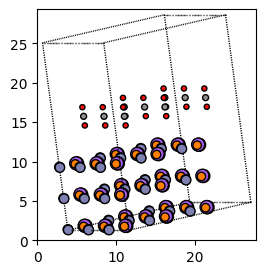

In [33]:
from pymatgen.core import Structure
from ase.visualize import view
from ase.io.extxyz import read_extxyz
from ase.io import read
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt

fpath = "POSCAR"
with open(fpath, "w") as f:
    f.write(agent_executor.memory.chat_memory.messages[1].content)

atoms = read(fpath)

fig, ax = plt.subplots(figsize=(3, 3))

plot_atoms(atoms * (3, 3, 1), ax, radii=0.5, 
           rotation=('-80x, -50y, 0z')
           )

# view(atoms*(3, 3, 1), viewer="x3d")

